In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from utils import *

C:\Users\tripl\AppData\Local\Temp\ipykernel_23884\804203489.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\tripl\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model3(game_info, obs=None):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    # Extract the data
    ids1 = game_info['coach1_ids']
    ids2 = game_info['coach2_ids']
    num_coaches = game_info['num_coaches']

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [3]:
# Fake data to see if this model gets same results as previous model
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

Loss = 0.117148: 100%|██████████| 2000/2000 [00:17<00:00, 116.51it/s] 


[400.4648666381836,
 406.12889409065247,
 263.513663649559,
 377.3201599121094,
 318.1245958805084,
 326.99312579631805,
 313.61190271377563,
 319.3546447753906,
 268.5282402038574,
 298.7238857746124,
 265.7281742095947,
 254.247896194458,
 225.61815798282623,
 233.34875082969666,
 193.12629294395447,
 222.5960841178894,
 246.39256417751312,
 206.20409202575684,
 192.9260082244873,
 176.4311581850052,
 173.4655386209488,
 173.58620858192444,
 117.80813336372375,
 125.72342836856842,
 153.04672801494598,
 141.42734336853027,
 114.38971376419067,
 113.16284561157227,
 103.80113410949707,
 114.859459400177,
 114.08231770992279,
 101.25600516796112,
 115.7616217136383,
 83.63126623630524,
 104.9892407655716,
 85.67215967178345,
 70.98637211322784,
 81.62944412231445,
 61.75970137119293,
 58.70173668861389,
 85.63549554347992,
 48.58227717876434,
 55.032142877578735,
 63.313716888427734,
 35.40737175941467,
 45.92148435115814,
 54.12559235095978,
 27.08939528465271,
 42.89806866645813,
 34

In [4]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(game_info, obs)

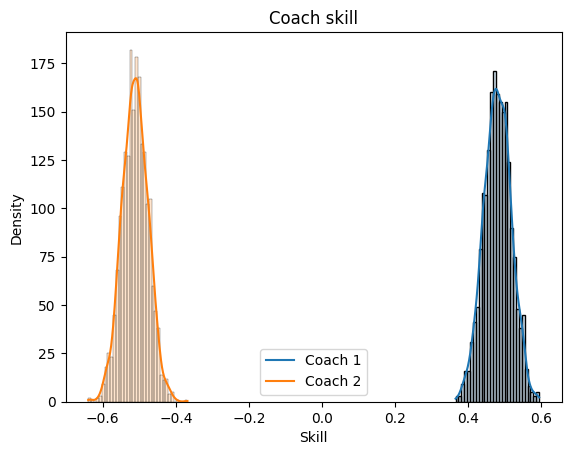

In [5]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")

plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [6]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

In [7]:
guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

Loss = 46.904207: 100%|██████████| 2000/2000 [00:15<00:00, 129.23it/s]


[536.1766502857208,
 483.403461933136,
 420.20418405532837,
 457.60513615608215,
 429.92156410217285,
 420.50537395477295,
 387.3868193626404,
 400.2178797721863,
 363.68839025497437,
 361.8073172569275,
 351.4207239151001,
 327.4956341981888,
 333.6508674621582,
 277.11046302318573,
 232.33965635299683,
 262.8710491657257,
 240.50096905231476,
 268.9091053009033,
 255.7908353805542,
 261.8547828197479,
 250.13541793823242,
 233.22059631347656,
 183.32612705230713,
 221.59526300430298,
 193.69783461093903,
 188.85015964508057,
 191.35441625118256,
 172.87555027008057,
 200.14033555984497,
 173.90502834320068,
 163.79886722564697,
 157.80550861358643,
 171.20383405685425,
 141.37822151184082,
 148.99910020828247,
 152.48254585266113,
 155.00135469436646,
 130.48780488967896,
 132.91657829284668,
 149.25037002563477,
 144.1091365814209,
 140.41461372375488,
 135.56557035446167,
 118.39936113357544,
 120.86277294158936,
 128.95002222061157,
 129.17068576812744,
 121.96999216079712,
 103.7

In [8]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

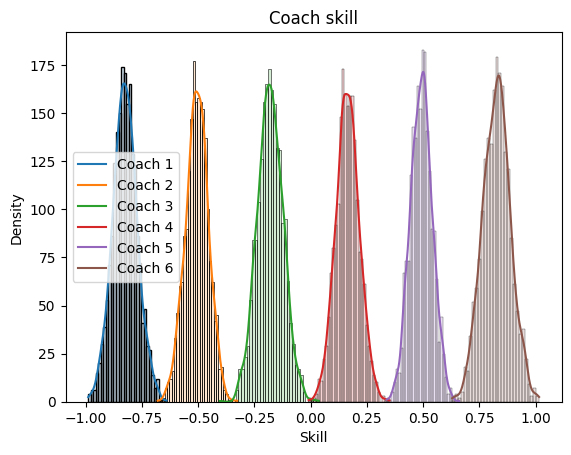

In [9]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [10]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

# alternative winrate and num games calculation
coach_winrates2 = np.zeros(num_coaches)
coach_num_matches2 = np.zeros(num_coaches)
coach_num_wins2 = np.zeros(num_coaches)
coach_num_draws2 = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach_num_matches2[id]  = len(df[(df['team1_coach_id'] == coach_id) | (df['team2_coach_id'] == coach_id)])
    coach_num_wins2[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 1)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 1)].shape[0]
    coach_num_draws2[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 0)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 0)].shape[0]
    coach_winrates2[id] = (coach_num_wins2[id] + 0.5 * coach_num_draws2[id]) / coach_num_matches2[id]

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
# might fuck up when several coaches has the same number of matches.
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

sorted_coaches2 = unique_coaches[indices[::-1]]
sorted_winrates2 = coach_winrates[indices[::-1]]
sorted_num_matches2 = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}



In [11]:
guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

Loss = 454666.523682: 100%|██████████| 2000/2000 [01:06<00:00, 29.99it/s]


[1937885.3852539062,
 1862071.234375,
 1790307.5356445312,
 1729165.4445800781,
 1654869.5759277344,
 1591150.1853027344,
 1531392.1069335938,
 1470152.9174804688,
 1414109.291015625,
 1361470.1442871094,
 1306681.8916015625,
 1249626.3479003906,
 1207575.0400390625,
 1161018.5510253906,
 1117842.8967285156,
 1072940.3754882812,
 1037610.4319458008,
 995062.3271484375,
 963219.9875488281,
 933063.46484375,
 901796.1875,
 872480.6643066406,
 843279.1428222656,
 821648.4606933594,
 799464.7841796875,
 770235.71875,
 755474.8701171875,
 737122.4558105469,
 718991.8325195312,
 704541.4870605469,
 685730.1528320312,
 671334.4614257812,
 661607.5610351562,
 649618.5439453125,
 640397.8784179688,
 632125.5559082031,
 624741.9499511719,
 615105.0725097656,
 612639.0288085938,
 602509.7028808594,
 599683.7661132812,
 599756.8012695312,
 592689.9357910156,
 586836.8347167969,
 582887.1938476562,
 579384.8564453125,
 579204.939453125,
 573737.6604003906,
 573573.4514160156,
 571293.3815917969,
 5

In [12]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

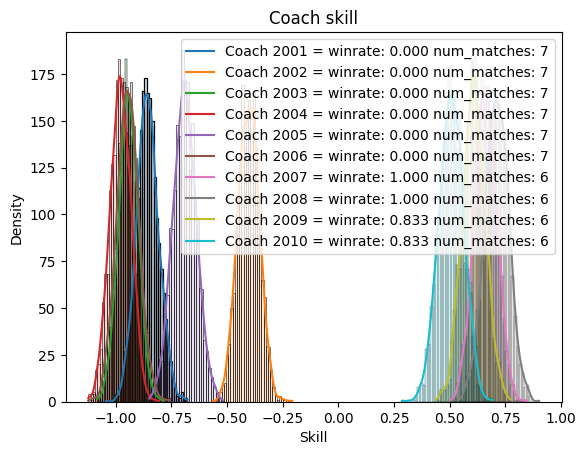

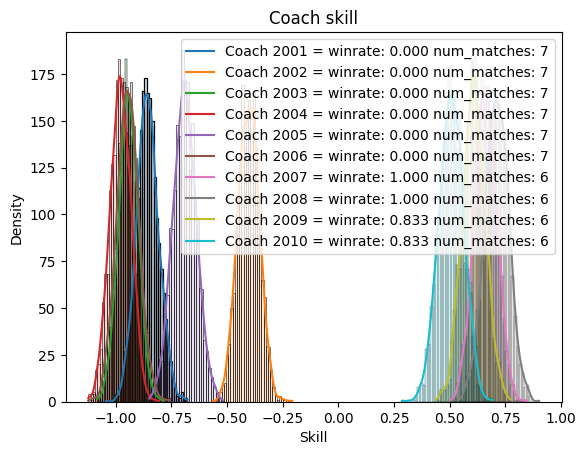

In [32]:
a = 2000
b = 2010

labels = []
for i in range(a,b):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.3f} num_matches: {int(sorted_num_matches[i])}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

labels = []
for i in range(a,b):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates2[i]:.3f} num_matches: {int(sorted_num_matches2[i])}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()



In [41]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# code for plotting the timeline of a coach
coach_index = 2008
coach_id = sorted_coaches2[coach_index]
print(coach_id.head())

mask = df['team2_coach_id'] == coach_id
df.loc[mask, 'team2_win'] *= -1
df.loc[mask, 'team1_win'] *= -1

coach1_df = df[df['team1_coach_id'] == coach_id].copy()
coach2_df = df[df['team2_coach_id'] == coach_id].copy()

coach_df = pd.concat([coach1_df, coach2_df])
coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
plt.figure(figsize=(20, 5))
plt.plot(coach_df['week_date'], np.cumsum(coach_df['team1_win']), 'r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
plt.gcf().autofmt_xdate()  # autoformat the x-axis date
plt.xlabel("Timeline")
plt.ylabel("Outcome")
plt.title(f"Timeline of outcomes for coach {coach_id}")
plt.show()


print((coach_df['team1_win'] == 1).sum())
print((coach_df['team1_win'] == 0).sum())
print((coach_df['team1_win'] == -1).sum())
print(coach_df['team1_win'])

ParserError: Error tokenizing data. C error: out of memory